In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# Introduction

This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know. 

We develop our models using TensorFlow and TensorFlow Probability (TFP). TFP is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability (TFP) and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).



As usual, the code is available on my GitHub.

# Deterministic Linear Regression

To make our process easier to follow, let's start by creating some data that follows a linear pattern. By generating this data syntetically, we have the advantage to know what was the exact generative process and, thus, we only need to find a way to get from the observations back to the generative process. It does not sound very complicated, but as soon as we get to more complex generative processes, our capacity to reverse engineer it will become increasingly challenging.

The data we'll be working with is artificially created from the following equation:

$$y_i = x_i + \frac{3}{8}\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed.

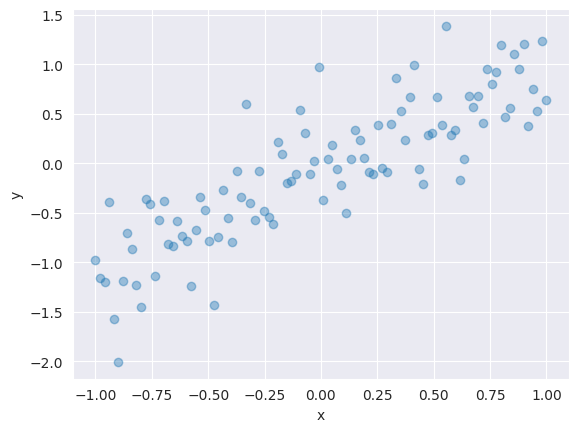

In [68]:
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + (3/8)*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### NumPy

### TensorFlow

In the case of TensorFlow and Keras, there are a few components that need to be defined before fitting the model to our data. First, we select the Keras API, since Keras offers two options: the sequential and the function API. In this case, we are going to use the sequential API but you can, as an exercise, try to reimplement our algorithms using the functional API. Next, we need to define our input for our  simple neural network. You can think of this input as a placeholder for the real data that later we are going to pass through the model. It serves the purpose of informing the model about the shape of the data to be ingested at some point in the future. Note that the first dimension of the input is not explicitly defined by us, since it is the batch size, and the model should be able to deal with any batch size. Recall that the batch size is the number of training examples used per training epoch. Now that we have the input specified, it is time to select the loss function. For the linear regression case, the usuall candidate is the Mean Squared Error. As a next step, we need to build our neural network architecture and for this we are going with the simplest form: a Dense layer with 1 unit. Finally, we can choose our optimizer (not really relevant at this stage) and the number of training epochs.

Let's define a model that receives each input as a length one vector (`input_shape`=(1,)), which means that we have only one feature. The model is predicting only one target variable, using the Dense layer defined above. We are compiling the model with the mean squared error loss, using the `RMSprop` optimizer and training for 400 epochs.

In [69]:
# Create linear regression via Sequential model
# Train the deterministic linear model using mean squared error loss

model = Sequential([
    Dense(1, input_shape=(1,))
])

model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=400, verbose=False)

In our last article, we saw how we could define `Variable` objects in TensorFlow. These objects are the ones being updated in the  training procedure. We did not define them explicitly this time, but  under the hood Keras have defined them for us. Let's check the values of  the trained variables after fitting the data. Since we are defining a  deterministic linear regression, we have two variables, the slope and  the intercept. In the above equation, the slope was equal to 1 and the  intercept to 0. We were able to retrieve them successfully.

In [88]:
model.weights

[<tf.Variable 'dense_11/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 0.97764325, -0.09925082]], dtype=float32)>,
 <tf.Variable 'dense_11/bias:0' shape=(2,) dtype=float32, numpy=array([-0.08040976, -0.7941095 ], dtype=float32)>]

We can plot our model and check how it looks against the observed data. In fact, it models the data quite well, except for the observed noise. We don't get any reference to the uncertainty of the prediction (there is significant uncertainty as we can see from the distance between the blue points and the red line). The deterministic linear regression is not able to to capture any information about the uncertainty on the process generation of the data - we call this type of uncertainty aleatoric. 

4/4 [==============================] - 0s 2ms/step


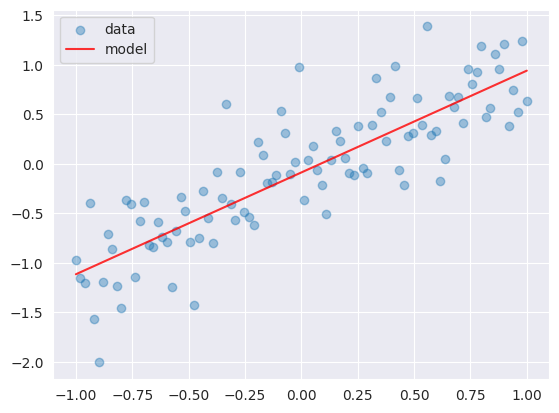

In [71]:
# Plot the data and the model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

# Probabilistic linear regression

We are now ready to put on a probabilistic hat. Our interest is to expand our deterministic approach to model the aleatoric uncertainty in the observed data. To be able to achieve it, we need to make use of the usual suspect: TensorFlow Probability. If you find that you need to review some concepts regarding TensorFlow Probability, feel free to check my earlier articles in this series.

To build our probabilistic model, we know that we need to add a Gaussian distribution somewhere (since we added Gaussian noise to our artificially generated data). We want to fit the same linear regression model but with two extra variables to be learned. Let's start with just the mean of the Gaussian noise.

Since we are happy with the previous architecture to model our data, let's define the same dense layer with one unit. Recall that this setup ensures that we have two variables added to the model, the slope and the intercept. To extend our model to be able to capture the mean of the Gaussian distribution that generated the noise, we are going to add a new layer to our architecture. This new layer is probabilistic and not a deterministic one. A generic way to incorporate any distribution into a Deep Learning architecture in Keras is to use the `DistributionLambda` layer from TensorFlow Probability. The `DistributionLambda` layer returns a distribution object, something that we are quite familiar with already from past articles. In this case, we are specifying a Gaussian distribution object.

Notice that the output of the previous layer is what defines the mean of the Gaussian distribution and we are assuming that the standard deviation is fixed (in our case 0.9). In other words, the constructor of the `DistributionLambda` has one required argument which is a function. As we are in a neural network setting, this function receives the output of the previous layer as its input and outputs a distribution object. In this case, we are using a lambda function to instantiate the `DistributionLambda` layer. The lambda function receives an input `t`, which is the output tensor of the previous Dense layer and returns a Gaussian distribution with a mean defined by the tensor `t`.

With this setup, the model returns a distribution object when it is called.

In [72]:
model = Sequential([
    Dense(1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=0.9))
])

In [73]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
 distribution_lambda_6 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


As usual, we need to specify our loss function. In the probabilistic case, and as we already saw several examples in previous articles, we need to define the negative log-likelihood as our loss function.

In [74]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Finally, we are ready to compile and fit our model.

In [75]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=400, verbose=False)

Conversely to what we have seen above, we can see below, on the plot of the right, that our new model is now capturing aleatoric uncertainty, which allows us to build confidence intervals. If we use an interval of two standard deviations of the mean, we are going to have 95% of the samples falling within these boundaries. We can easily see that this is not the case in the plot below. We have 100% of the values inside the interval. The reason for this is that we did not infer the standard deviation, we used a manually input value and it is far from the true value.

On the left plot, we can see one of the main advantages of using a probabilistic mode: it is possible to generate samples that follow the same generative process as the observations. Obviously, we suffer from the same problem in the samples that we are generating, they are much more spread than the true data.

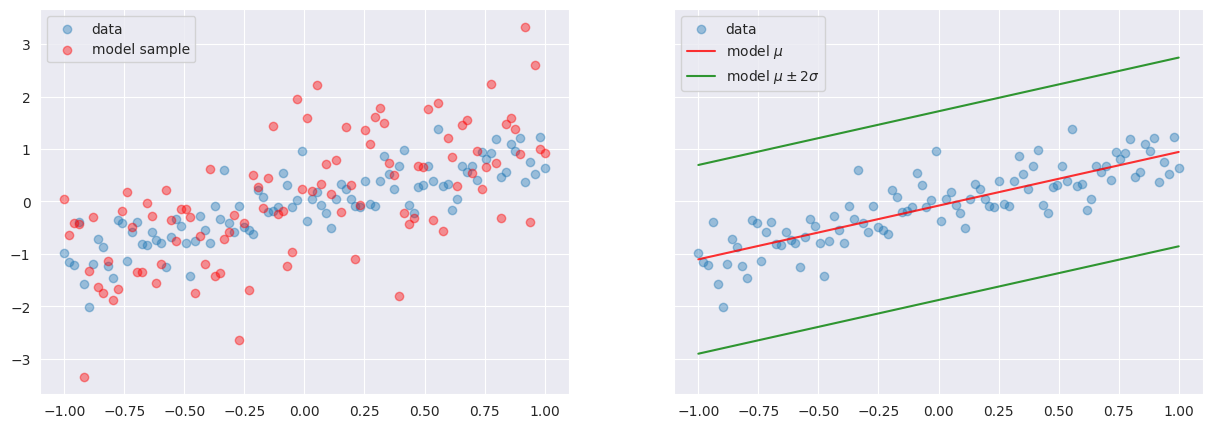

In [76]:
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

Our next step is then to add the standard deviation as a parameter of the model. Remember that the standard deviation is strictly positive, so we also need to add this constraint to our model. We use a SoftPlus function, which is a smooth approximation to the ReLU function and can indeed constrain the output of a model to always be positive.

In [77]:
model = Sequential([
    Dense(2, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
])

In [78]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
 distribution_lambda_7 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Our loss function is exactly the same as before.

In [79]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

And, thus, we are ready to compile and fit our new model.

In [99]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=500, verbose=False)

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

Notice that we are able to capture the correct mean of the Gaussian noise and, this time, we are also able to learn the correct standard deviation value.

In [100]:
print("True μ: ", 1)
print("Estimated μ: ", y_hat.numpy().mean())
print("True σ: ", 3/8)
print("Estimated σ: ", y_sd.numpy().mean())

True μ:  1
Estimated μ:  -0.06890577
True σ:  0.375
Estimated σ:  0.37177968


Now, we are finally able to capture the aleatoric uncertainty correctly! The confidence interval looks good, as we can see that roughly 95% of the samples are inside its boundaries. As a result, we are now able to generate new samples using the same process that we just learned from the data.

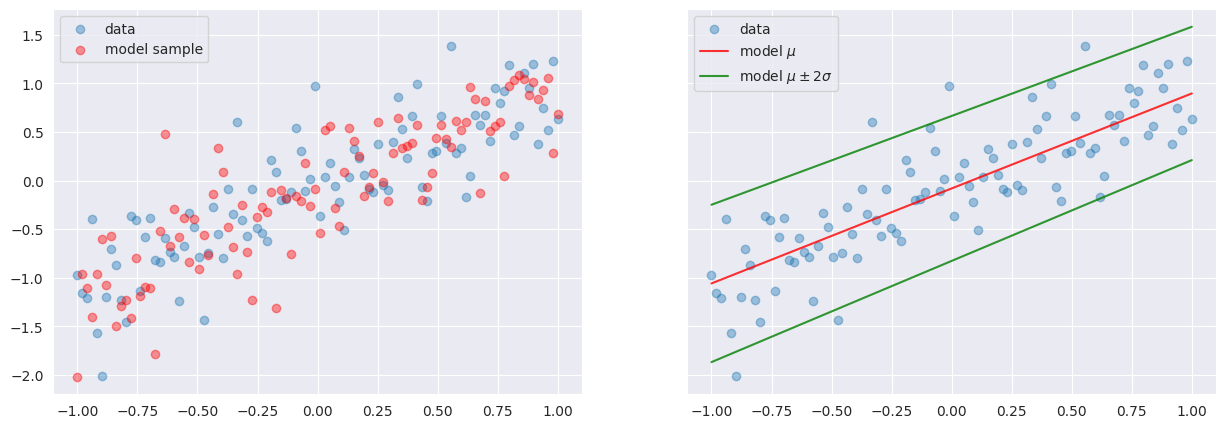

In [83]:
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

# Conclusion

This article introduced a new way to look at linear regression from the probabilistic perspective. We started by fitting a deterministic linear regression and while we were able to capture the slope and intercept correctly, we saw that we knew nothing about the uncertainty in the process generation of the data - we call this type of uncertainty aleatoric. We then expanded this approach by adding one more layer to our very simple Deep Learning architecture. Instead of adding a conventional layer, we added a probabilistic one, which returns a distribution object. By specifying our model with two additional variables defined in the new probabilistic layer, we were able to learn the mean and standard deviation of the Gaussian noise that was used to generate the artificial data. By using these parameters, we were also able to build confidence intervals but, more importantly, to generate new samples using the same process that we have learned from the data.

Next week, we will extend this approach to non-linear data. See you then!

# References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)